<a href="https://colab.research.google.com/github/davidnol/CE6003/blob/master/CE6003_Etivity_assignment2_David_Nolan_20146744.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity 2: Deep Convolutional Neural Network on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep convolutional neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow 2.5.  

## (a) Introduction

 In this assignment to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The goal of this Etivity is to build and train your own Deep Convolutional Neural Network. This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to focus on developing the architecture & code for your network. 

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code your neural network model in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Etivity.  


## (b) Notes on Architecture selection & development

A key task in this Etivity is selecting an appropriate architecture. You can base your archicture on any of the types seen in the lecture notes or published literature. It is however recommended to ensure you can get a standard CNN type architecture to successfully train before attempting a more complex architecture or adding further enhancements to your network to improve performance.
   Many published networks are designed to work with larger sized input images (e.g. 224 x 224). Often large (e.g. 7 x 7) convolution kernels and pooling layers are first applied to the input image, which agressively reduce the spatial dimensions of the network. As the CIFAR-10 dataset only has 32 x 32 images, it is recommended that just an intial 3 x 3 convolution is applied to the input image (as shown in the figure below), which will preserve the spatial dimensions of the input, before any other layers are added. It is expected that as you add more layers to the network the spatial dimensions will reduce and there will also be a corresponding increase the number of channels of the output feature map. The architecture will end with a [global average pooling layer](https://arxiv.org/pdf/1312.4400.pdf) and a fully-connected layer (called a *dense* layer in Keras/Tensorflow) with softmax activation which gives us our 10 class predictions. A skeleton code has been provided for any general architure using this structure in section 3.
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/Architecture_outline.jpg?raw=true)


#House Keeping

In [ ]:
from __future__ import print_function

%tensorflow_version 2.x
import tensorflow as tf
import sys
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np

import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

from tensorflow.keras.utils import to_categorical
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Populating the interactive namespace from numpy and matplotlib


To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 17 13:55:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path = '/content/drive/MyDrive/Colab Notebooks/DavidNolan/Diagnostic Learning Curves/'

#1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [ ]:
# load dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

170508288/170498071 [==============================] - 12s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


# 2. Prepare Data & Compiling Model Code

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

Plot some examples of the training dataset.

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

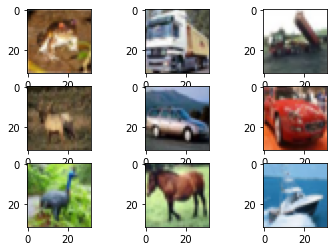

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i])
# show the figure
plt.show()

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	# ...
	return model

#3. Baseline Model using alternative no. of VGG Blocks

In [ ]:
# define cnn model - 1 VGG Block
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
  plt.figure(figsize=(20, 8))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(loc='upper right')
  plt.ylim([0,2.0])
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
	# save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(Path+"One-VGG-Block" + '_plot.png', index=True)
  plt.close()

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [ ]:
# Run the test harness
run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


> 66.720


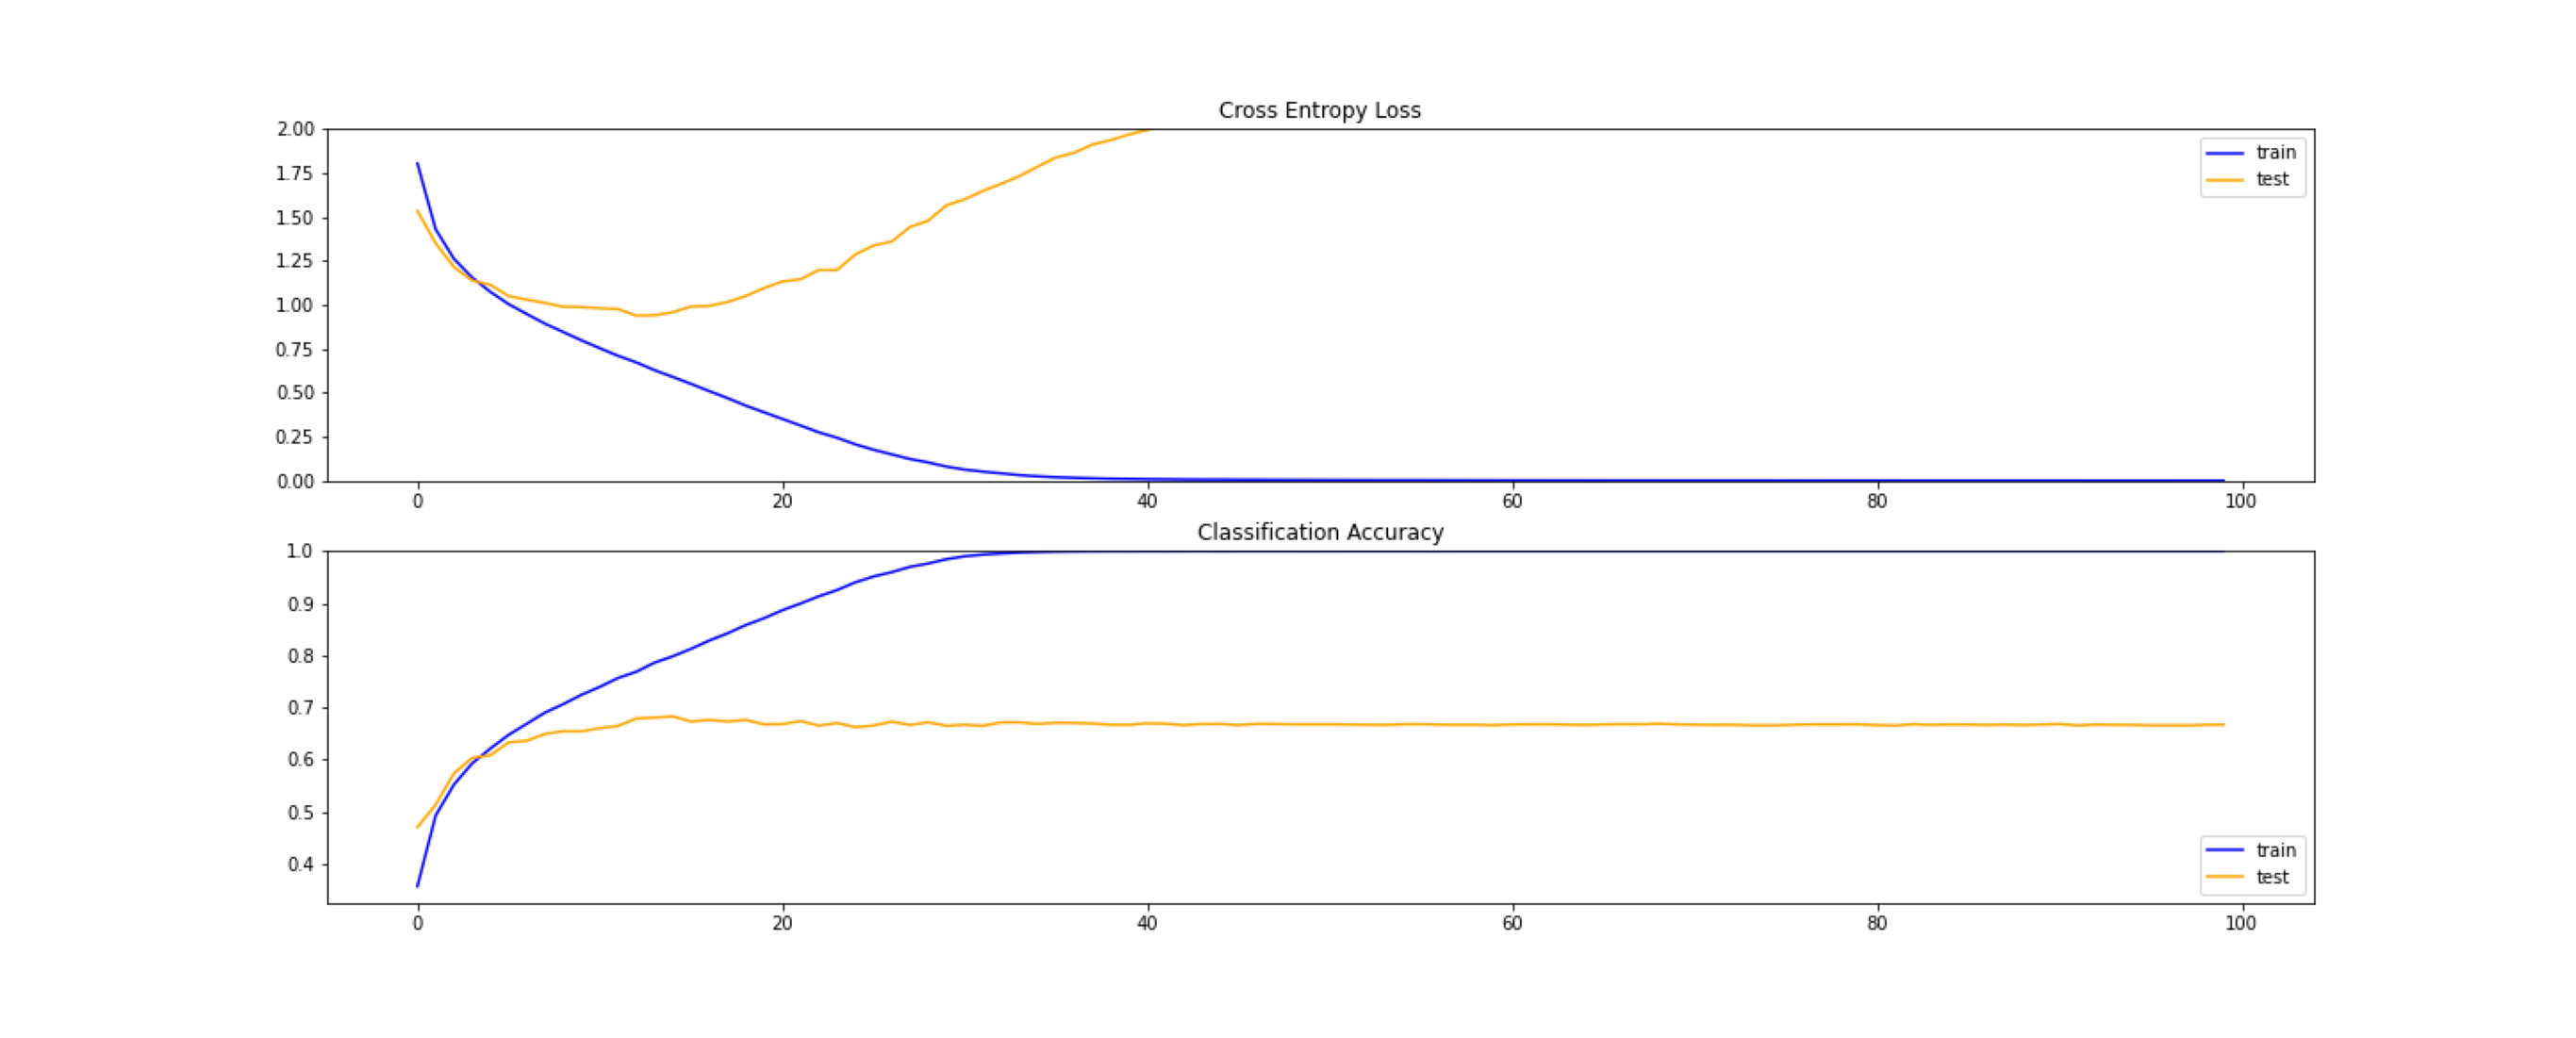

In [ ]:
img = mpimg.imread(Path+"One-VGG-Block" + '_plot.png')
plt.figure(figsize=(80, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In this case, we can see that the model rapidly overfits the test dataset. This is clear if we look at the plot of loss (top plot), we can see that the model’s performance on the training dataset (blue) continues to improve whereas the performance on the test dataset (orange) improves, then starts to get worse at around 15 epochs.

In [ ]:
# define cnn model - 2 VGG Blocks
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
  plt.figure(figsize=(20, 8))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(loc='upper right')
  plt.ylim([0,2.0])
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
	# save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(Path+"Two-VGG-Blocks" + '_plot.png', index=True)
  plt.close()

In [ ]:
# Run the test harness
run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


> 70.330


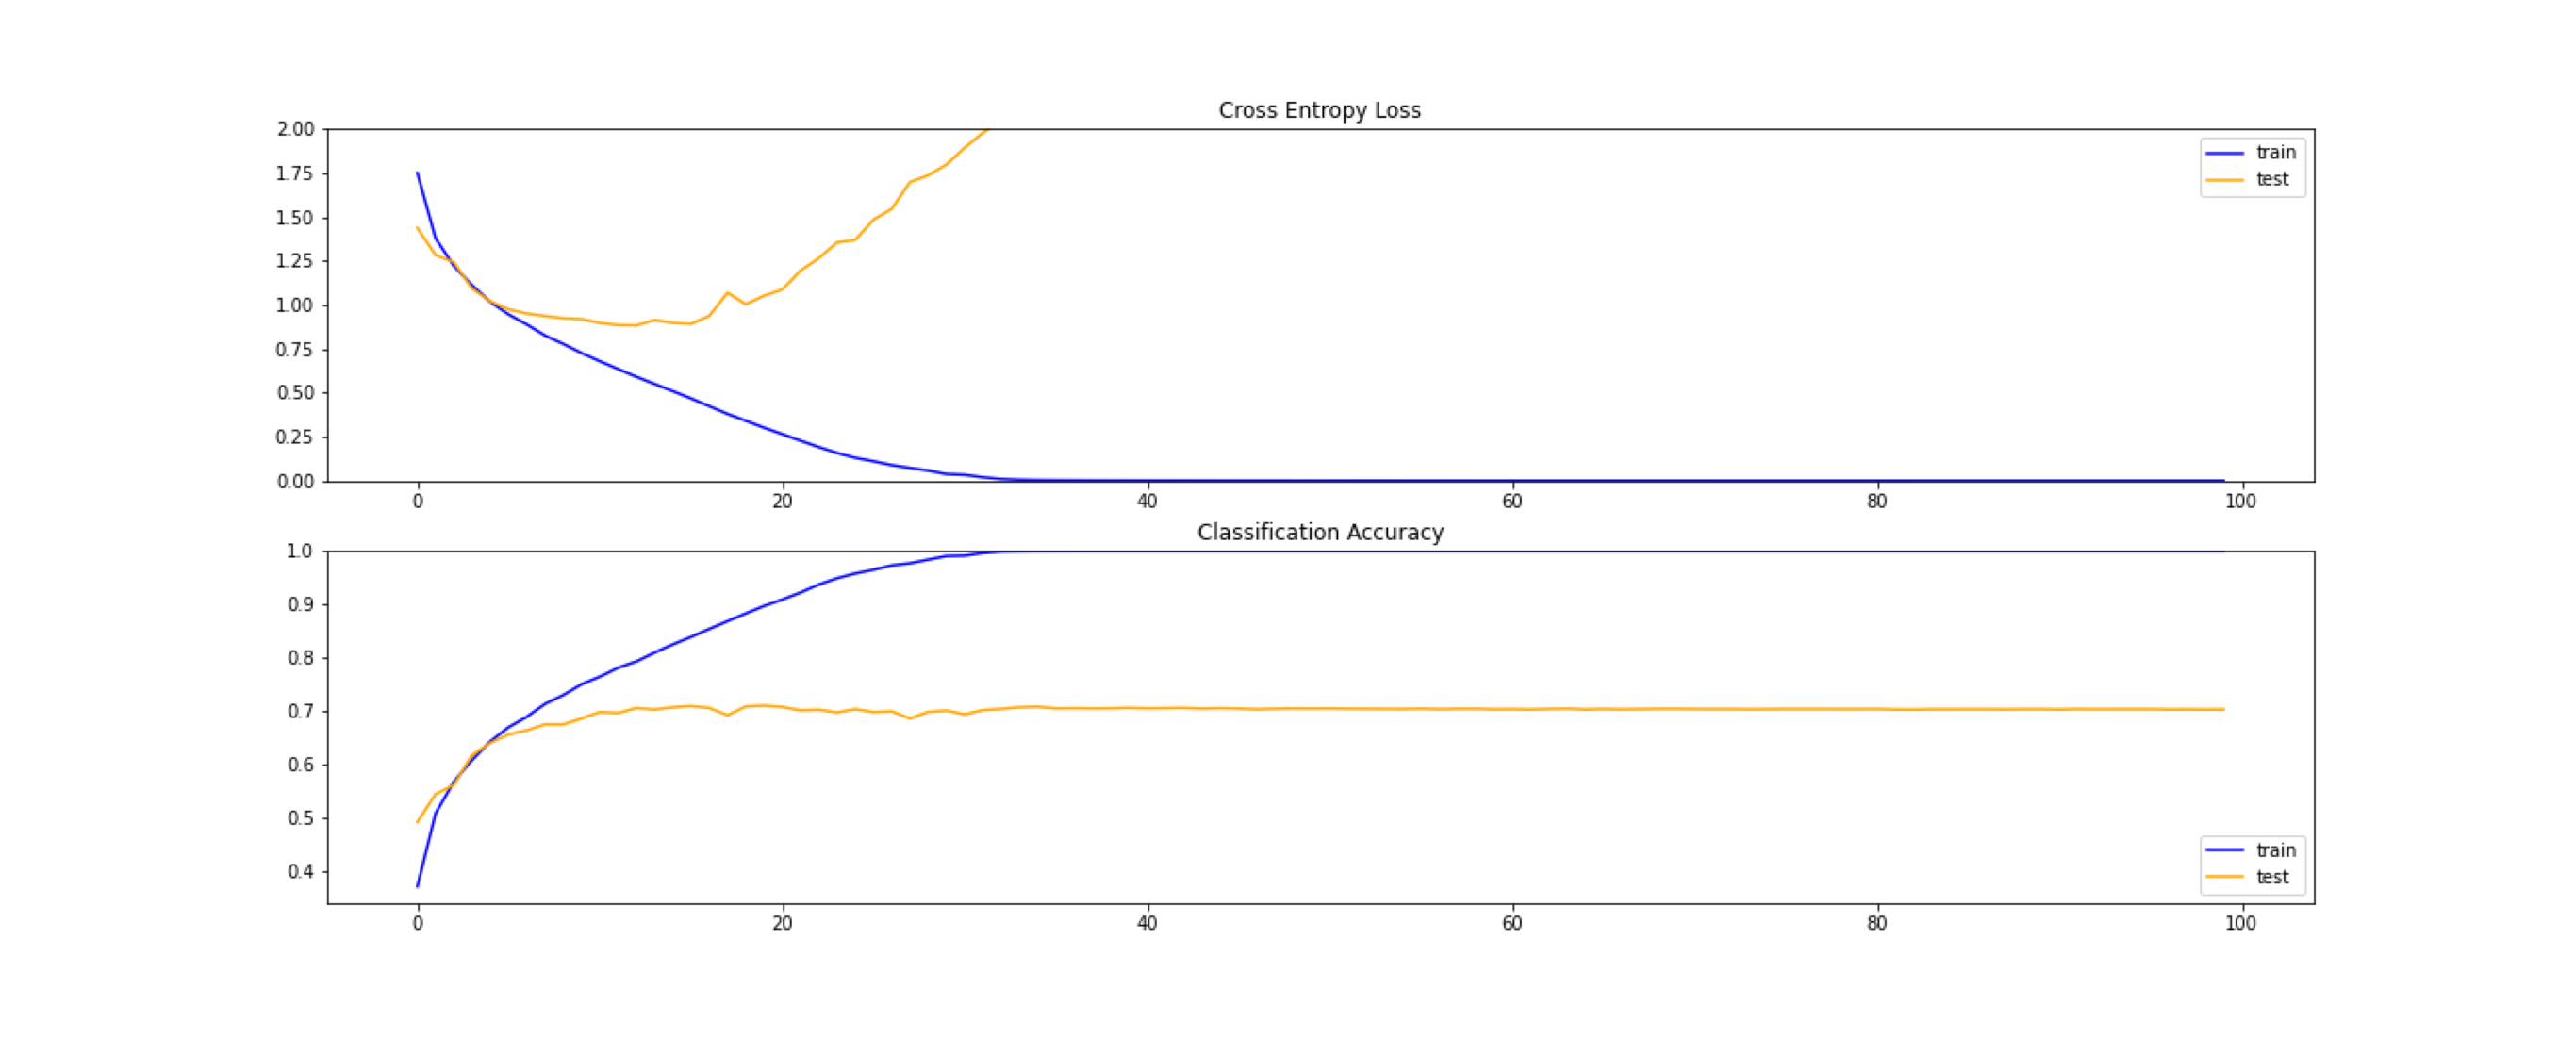

In [ ]:
img = mpimg.imread(Path+"Two-VGG-Blocks" + '_plot.png')
plt.figure(figsize=(80, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In this case, we can see that the model with two blocks performs better than the model with a single block: a good sign.

In [ ]:
# define cnn model - 3 VGG Blocks
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
  plt.figure(figsize=(20, 8))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(loc='upper right')
  plt.ylim([0,2.0])
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
	# save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(Path+"Three-VGG-Blocks" + '_plot.png', index=True)
  plt.close()

In [ ]:
# Run the test harness
run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


> 74.760


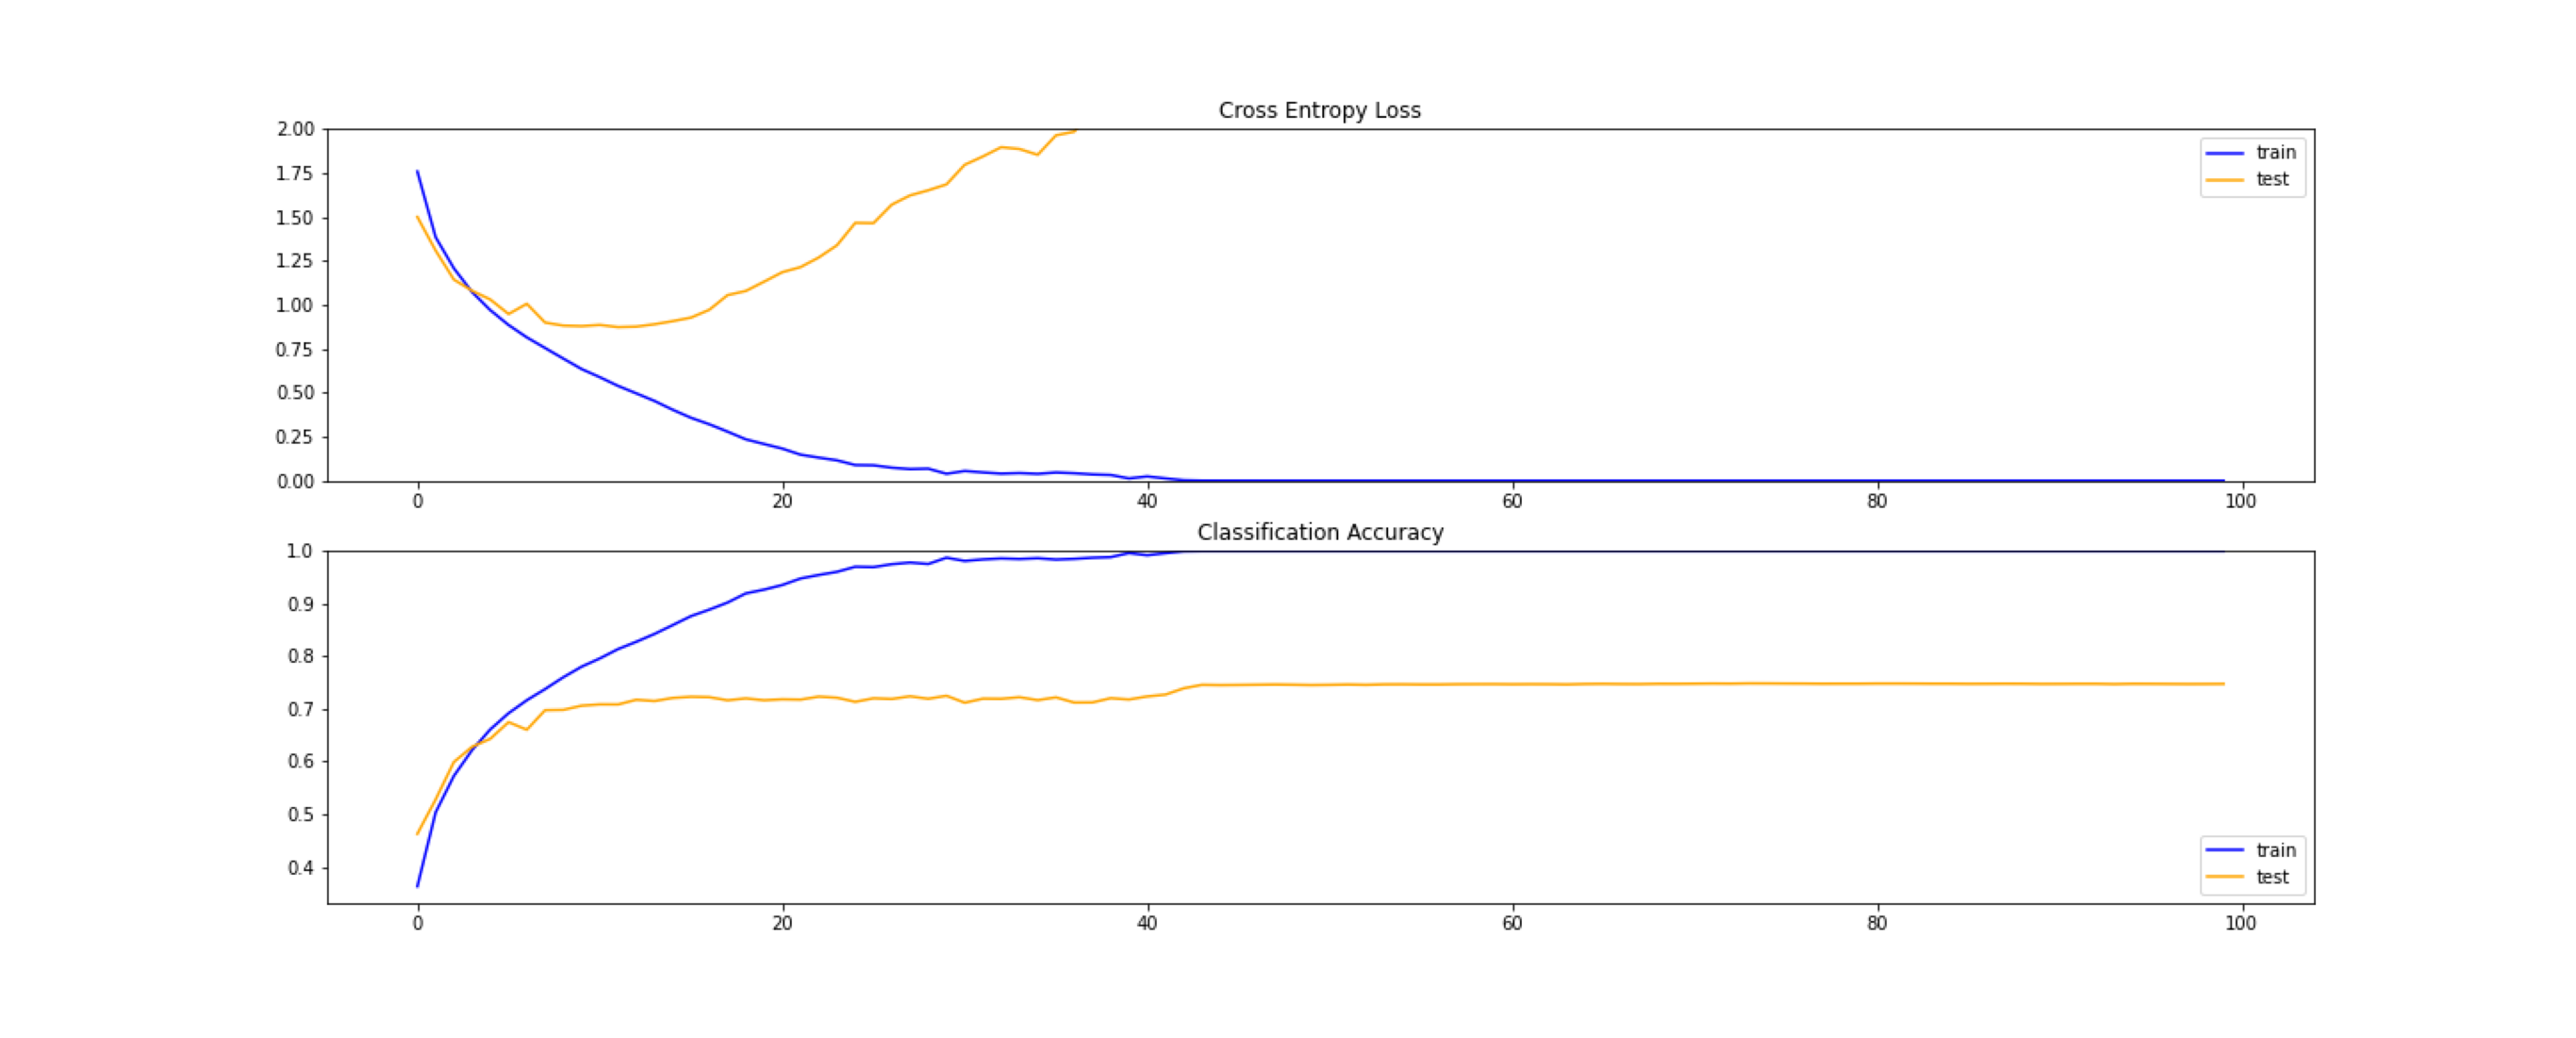

In [ ]:
img = mpimg.imread(Path+"Three-VGG-Blocks" + '_plot.png')
plt.figure(figsize=(80, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In this case, yet another modest increase in performance is seen as the depth of the model was increased.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

VGG 1: 66.720%

VGG 2: 70.330%

VGG 3: 74.760%

In all cases, the model was able to learn the training dataset, showing an improvement on the training dataset that at least continued to 40 epochs, and perhaps more. This is a good sign, as it shows that the problem is learnable and that all three models have sufficient capacity to learn the problem.

The results of the model on the test dataset showed an improvement in classification accuracy with each increase in the depth of the model. It is possible that this trend would continue if models with four and five layers were evaluated, and this might make an interesting extension. Nevertheless, all three models showed the same pattern of dramatic overfitting at around 15-to-20 epochs.

These results suggest that the model with three VGG blocks is a good starting point or baseline model for our investigation.

The results also suggest that the model is in need of regularization to address the rapid overfitting of the test dataset. More generally, the results suggest that it may be useful to investigate techniques that slow down the convergence (rate of learning) of the model. This may include techniques such as data augmentation as well as learning rate schedules, changes to the batch size, and perhaps more.

# 4. Model Training - Optimising the model accuracy through Dropout Reg., Data Augmentaton & Batch Normalisation



The below was too much for the poor aul GPU and Collab and crashed after 4hrs. My expectation was from what I have read is that the below would add approdx. ~10% improvement. Moving to using the VGG-3 and trying different optimizer than SGD to see if this improves speed and accuracy. Will then use that as final model to evaluate and test against an image from Cifar.

#Using different Optimizers - in a bid to increase speed and accuracy

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam


In [ ]:
#Adam
# define cnn model - VGG-3 with Adam Optimizer
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
  plt.figure(figsize=(20, 8))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(loc='upper right')
  plt.ylim([0,2.0])
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
	# save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(Path+"Three-VGG-Blocks-Adam-Optimizer" + '_plot.png', index=True)
  plt.close()

	# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
 # entry point, run the test harness
run_test_harness()

> 76.570


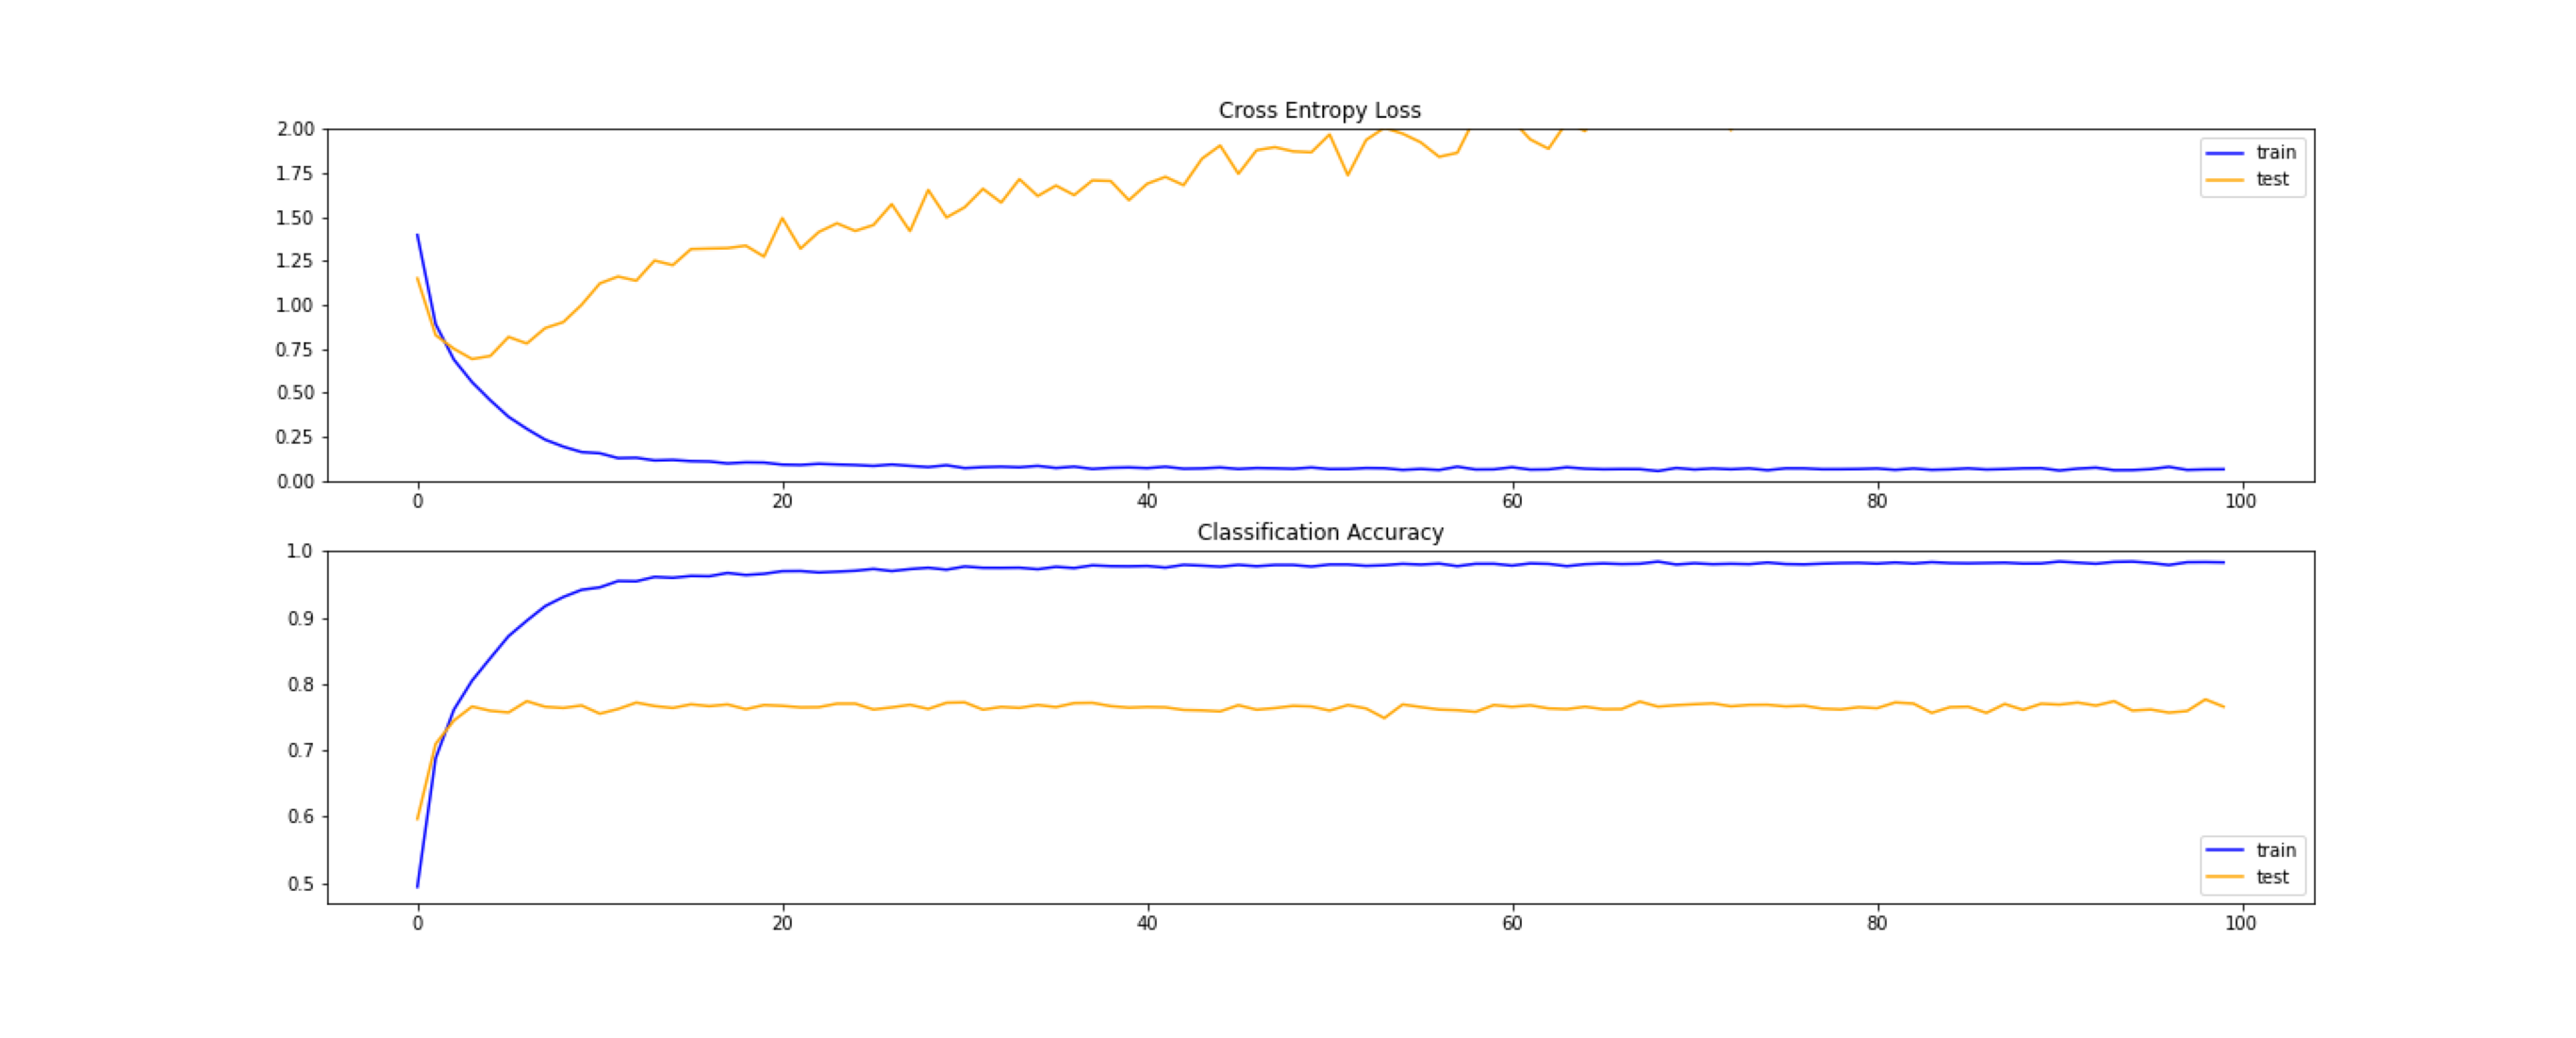

In [ ]:
img = mpimg.imread(Path+"Three-VGG-Blocks-Adam-Optimizer" + '_plot.png')
plt.figure(figsize=(80, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# define cnn model - VGG-3 with RMSprop Optimizer
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
	model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
	return model

  # plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
  plt.figure(figsize=(20, 8))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(loc='upper right')
  plt.ylim([0,2.0])
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
	# save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(Path+"Three-VGG-Blocks-RMSprop-Optimizer" + '_plot.png', index=True)
  plt.close()

	# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

	# entry point, run the test harness
run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


> 73.080


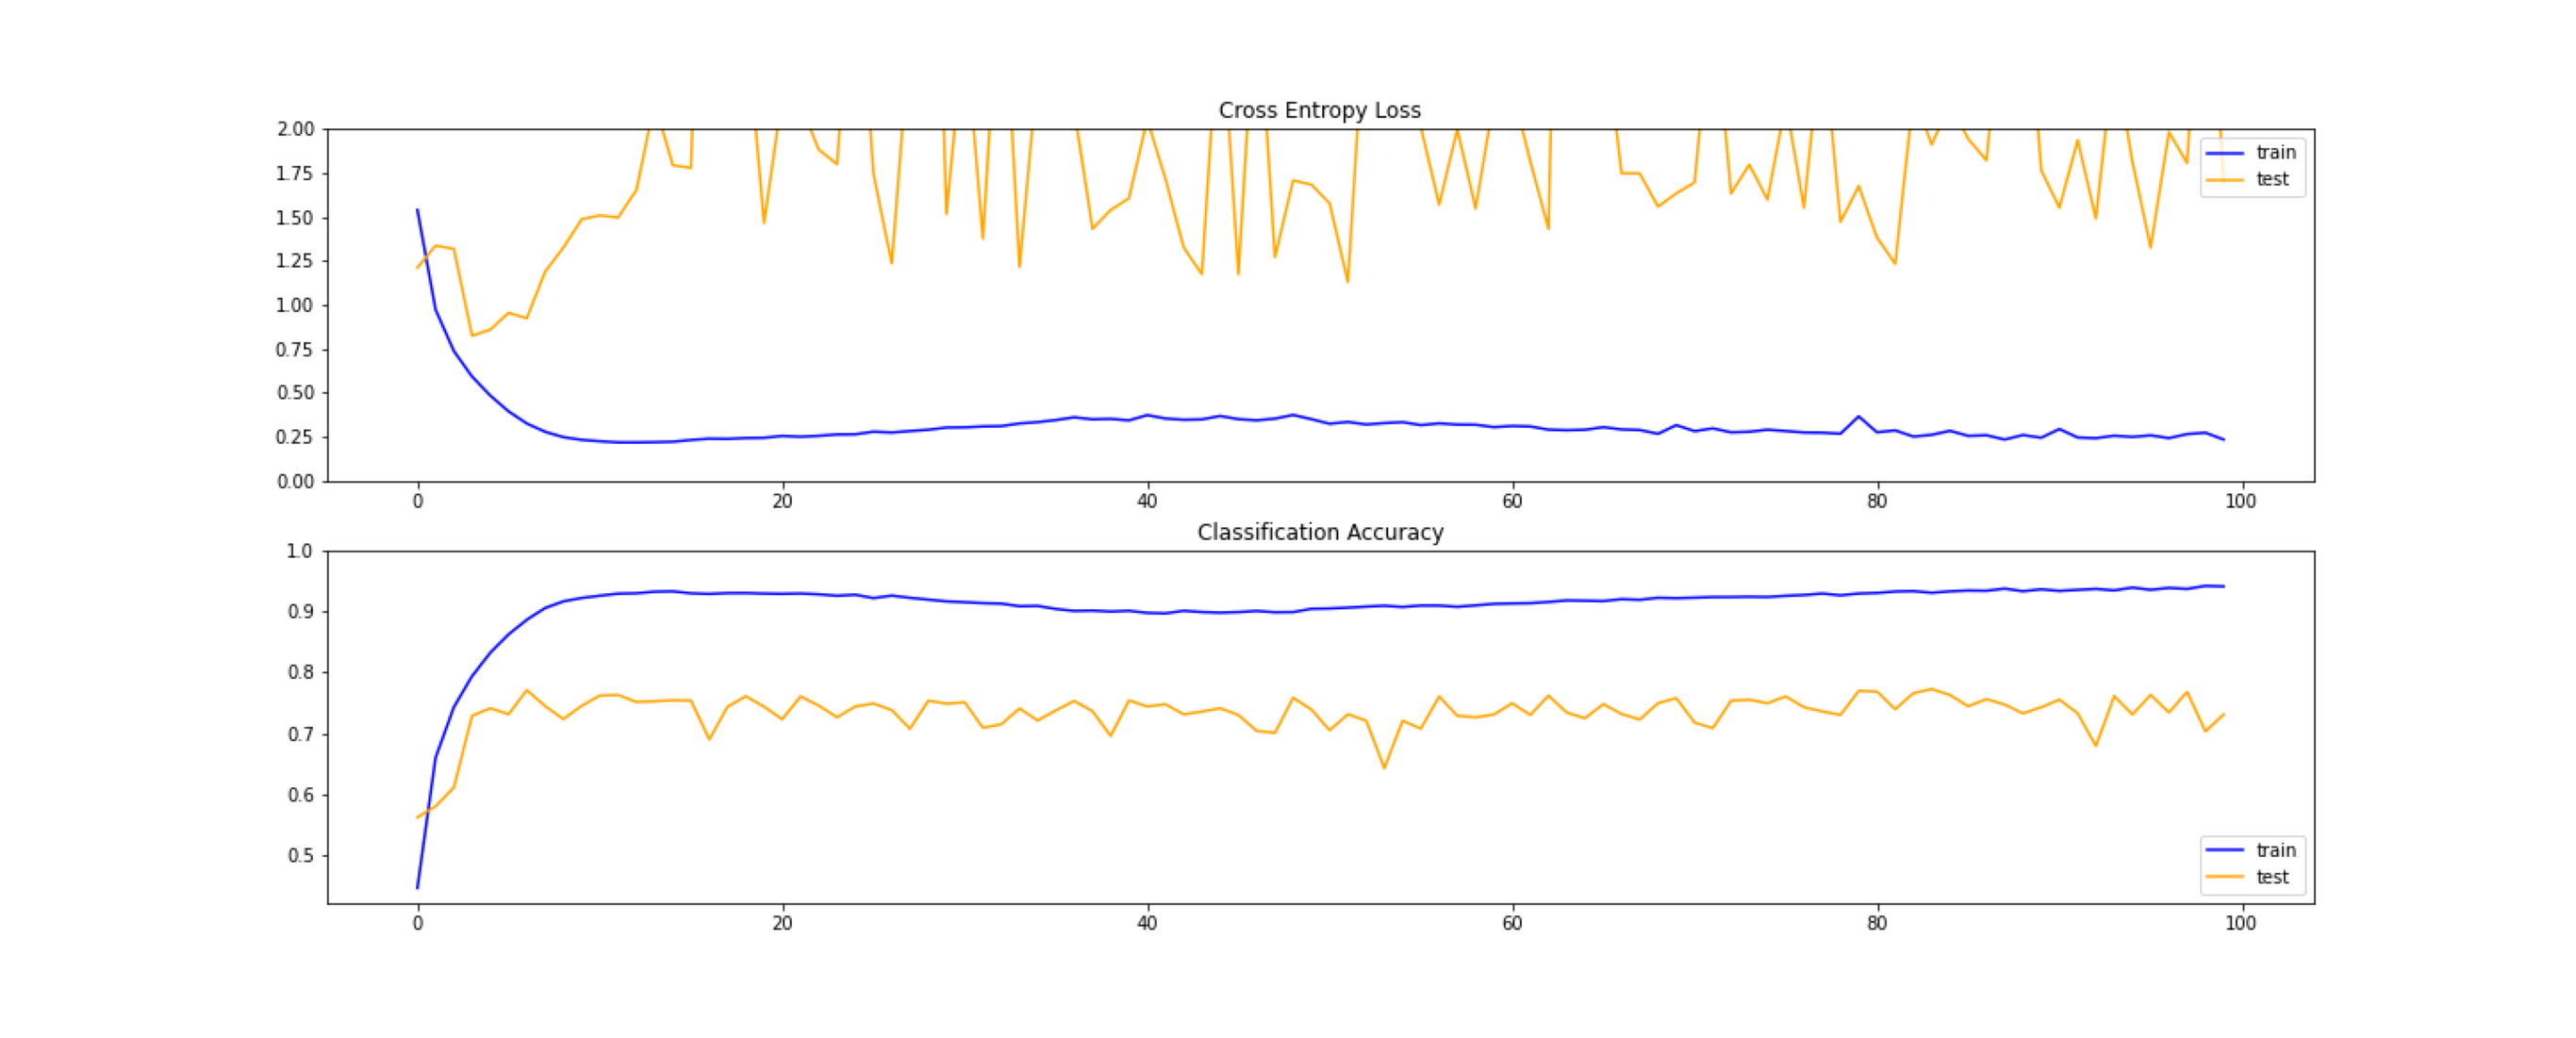

In [ ]:
img = mpimg.imread(Path+"Three-VGG-Blocks-RMSprop-Optimizer" + '_plot.png')
plt.figure(figsize=(80, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# load model
	model = load_model(Path+'final_cnn_model.h5')
	# evaluate model on test dataset
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
 
# entry point, run the test harness
run_test_harness()

> 76.560


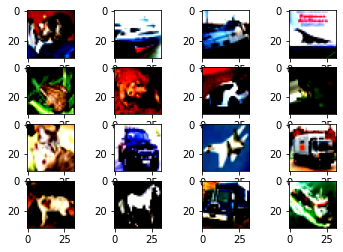

['automobile', 'ship', 'ship', 'ship', 'frog', 'dog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'frog', 'dog', 'truck', 'airplane']


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

##Loading the trained model 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
# mean-std normalization
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
show_imgs(x_test[:16])
 
# Load trained CNN model
model = load_model(Path+'final_cnn_model.h5')
model.load_weights(Path+'final_cnn_model.h5')
 
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[:16]),1)
print([labels[x] for x in indices])

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch) 
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

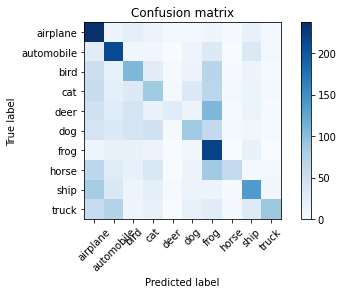

In [ ]:
 #https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.35      0.70      0.47       337
  automobile       0.44      0.63      0.52       338
        bird       0.35      0.35      0.35       306
         cat       0.31      0.27      0.29       323
        deer       0.59      0.09      0.16       297
         dog       0.40      0.27      0.32       325
        frog       0.32      0.72      0.44       307
       horse       0.73      0.19      0.30       317
        ship       0.48      0.42      0.45       326
       truck       0.71      0.27      0.40       324

    accuracy                           0.40      3200
   macro avg       0.47      0.39      0.37      3200
weighted avg       0.47      0.40      0.37      3200



(32, 10)
(32,)
Predictions:
 [2 5 6 9 0 5 7 0 3 0 6 2 7 1 2 0 0 3 1 6 6 0 0 6 0 8 6 8 1 3 6 0]


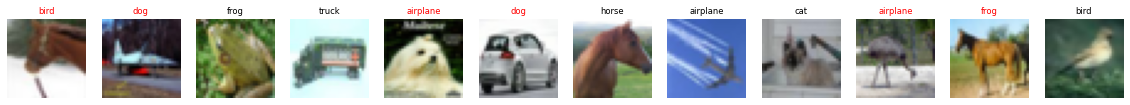

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')
  
  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1 

##Dropout, Data Augmentation & Batch Normalization - to improve model accuracy and validation accuracy

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
  plt.figure(figsize=(20, 8))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend(loc='upper right')
  plt.ylim([0,2.0])
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
	# save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(Path+"Three-VGG-Blocks-Dropout-Data-Augmentation-Batch-Norm" + '_plot.png', index=True)
  plt.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(trainX, trainY, batch_size=64)
	# fit model
	steps = int(trainX.shape[0] / 64)
	history = model.fit(it_train, steps_per_epoch=steps, epochs=400, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# save model
	model.save(Path+'final_model.h5')
	# learning curves
	summarize_diagnostics(history)
 # entry point, run the test harness
run_test_harness()


> 90.940


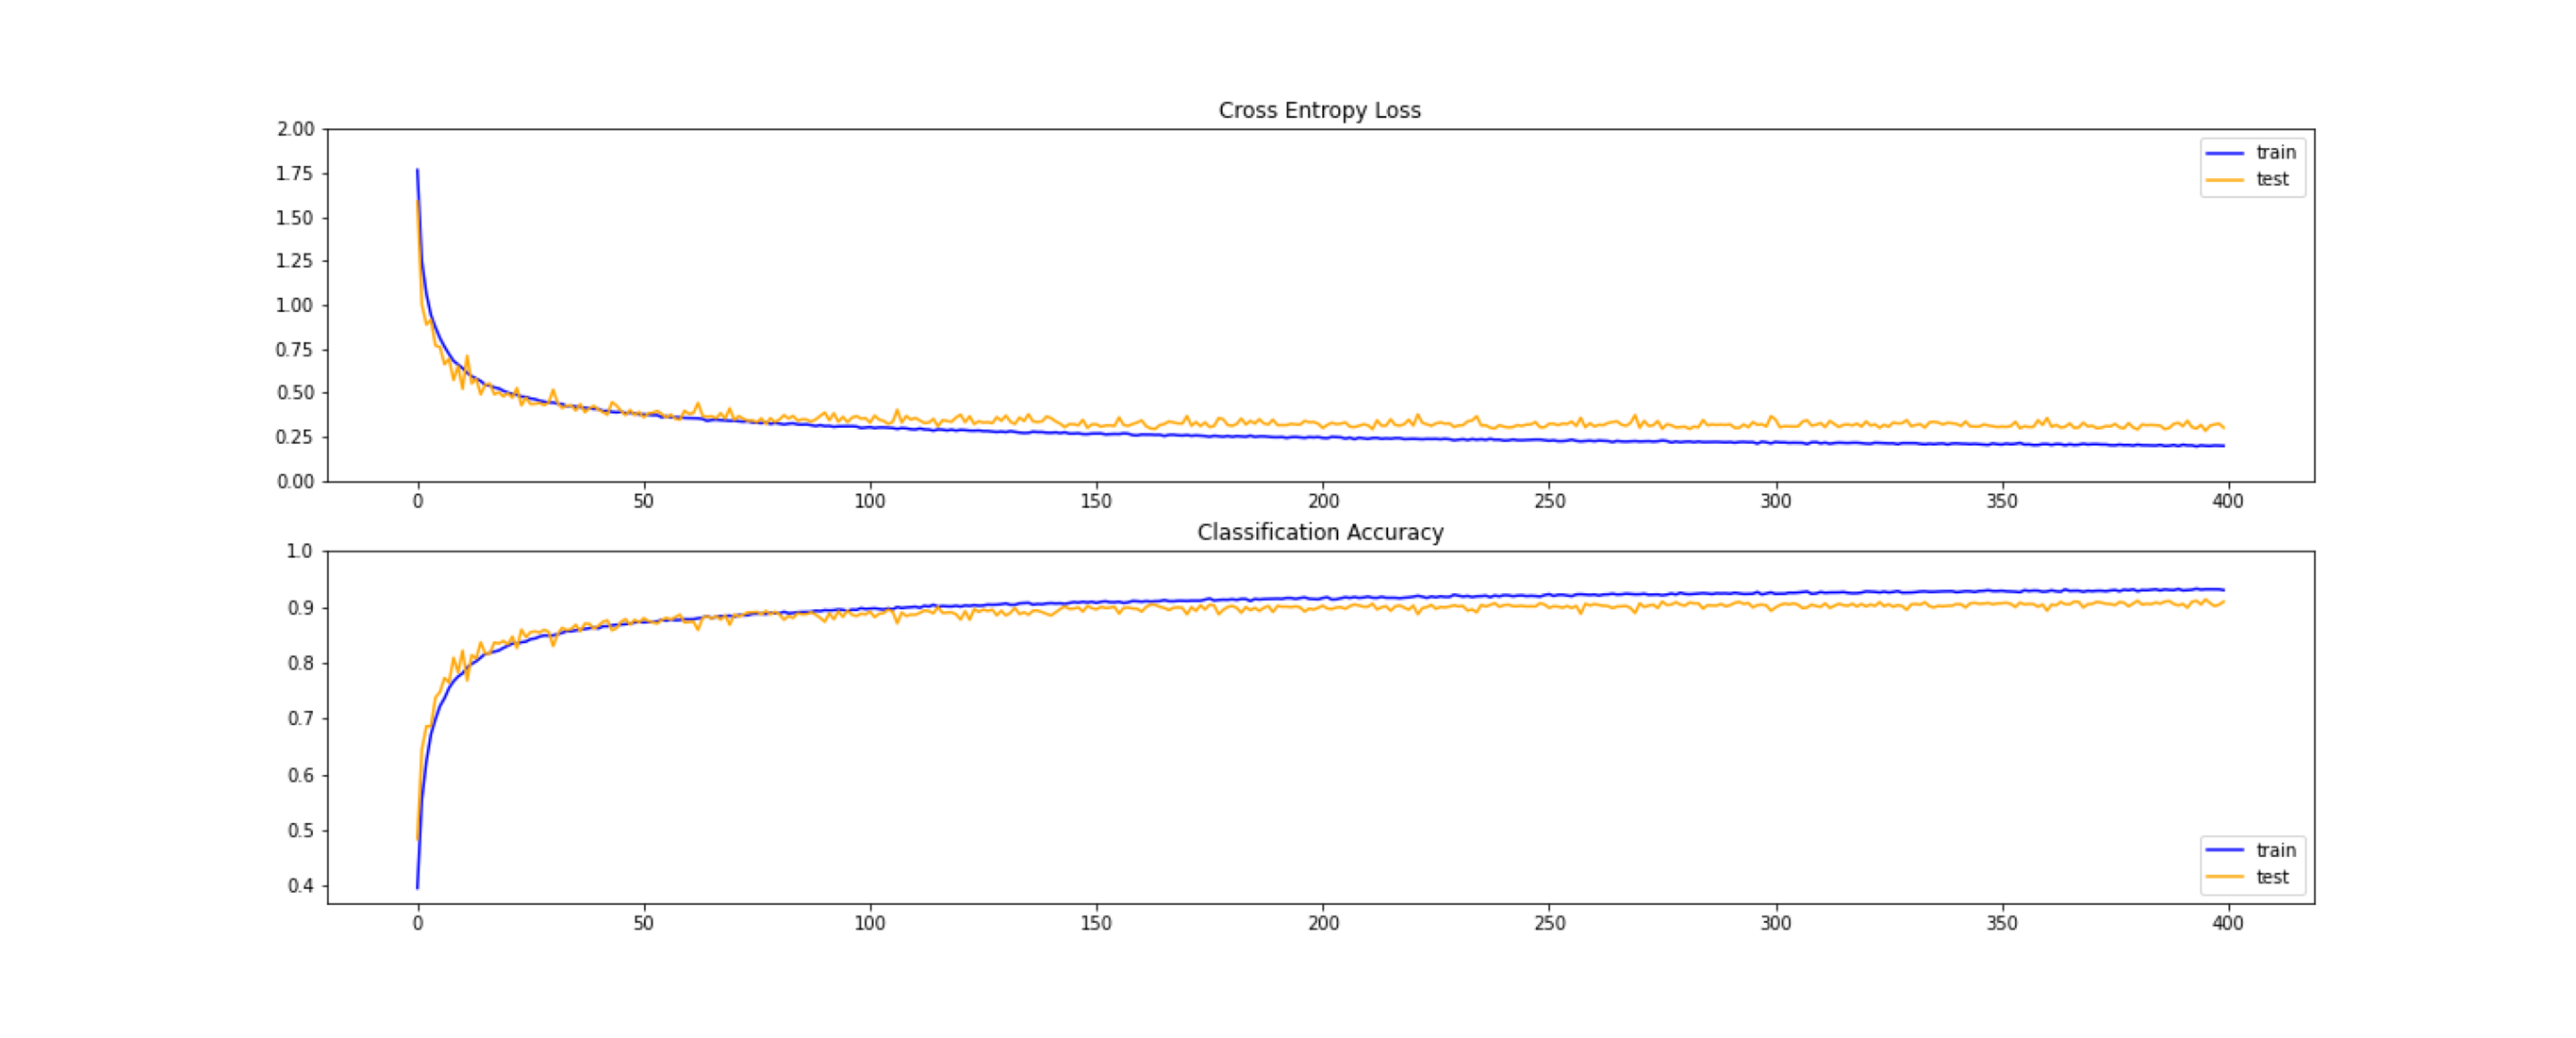

In [ ]:
img = mpimg.imread(Path+"Three-VGG-Blocks-Dropout-Data-Augmentation-Batch-Norm" + '_plot.png')
plt.figure(figsize=(80, 20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

# 6. Model Testing - Evaluate & Predict 

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# load model
	model = load_model(Path+'final_model.h5')
	# evaluate model on test dataset
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
 
# entry point, run the test harness
run_test_harness()

> 90.940


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img
 
# load an image and predict the class
def run_example():
	# load the image
	img = load_image(Path+'sample_image.png')
	# load model
	model = load_model(Path+'final_model.h5')
	# predict the class
	result = model.predict(img)
	print(result[0])
 
# entry point, run the example
run_example()

[9.3992270e-08 6.6595029e-10 5.5156939e-05 8.7530843e-06 9.9976200e-01
 4.8254489e-05 8.6131649e-06 1.1717172e-04 3.3372302e-08 1.7557648e-08]


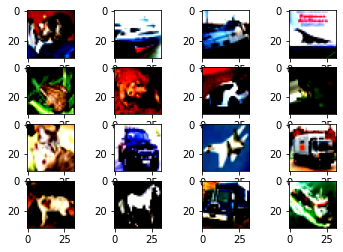

['ship', 'automobile', 'automobile', 'automobile', 'dog', 'automobile', 'ship', 'ship', 'cat', 'automobile', 'automobile', 'automobile', 'ship', 'ship', 'automobile', 'automobile']


In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

##Loading the trained model 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
# mean-std normalization
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
show_imgs(x_test[:16])
 
# Load trained CNN model
model = load_model(Path+'final_model.h5')
model.load_weights(Path+'final_model.h5')
 
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[:16]),1)
print([labels[x] for x in indices])

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch) 
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

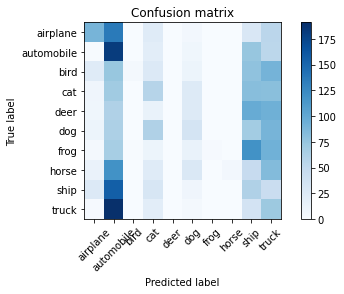

In [ ]:
 #https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.49      0.27      0.35       337
  automobile       0.16      0.54      0.25       338
        bird       0.80      0.01      0.03       306
         cat       0.20      0.18      0.19       323
        deer       0.00      0.00      0.00       297
         dog       0.22      0.10      0.14       325
        frog       1.00      0.01      0.01       307
       horse       1.00      0.02      0.03       317
        ship       0.09      0.19      0.12       326
       truck       0.10      0.22      0.13       324

    accuracy                           0.16      3200
   macro avg       0.41      0.15      0.12      3200
weighted avg       0.40      0.16      0.13      3200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(32, 10)
(32,)
Predictions:
 [9 8 9 1 5 1 9 0 1 9 1 8 3 9 1 1 1 1 1 1 9 8 8 8 5 8 8 0 8 1 1 8]


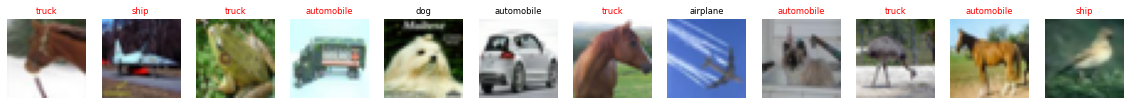

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')
  
  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1 

###NOTE:
My take on the above from what I have read is that I am overfitting, there is 90% training accuracy but low % validation rate. With a lowering in Augmentation I am confident this could be improved on. At this point I want to try a different approach leveraging more of the provided code as part of the e-tivity leveraging GoogLeNet architecture.

##Alternative approach to avoid the over fitting above

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from keras.layers import concatenate
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import numpy as np

In [ ]:
!pip install pysgd

In [ ]:
#Load Dataset
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test') 

In [ ]:
def data_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5
  label = tf.cast(label, tf.float32)
  return image,label

In [ ]:
def gen_tr_datasets(src_dataset):    
    # Define Datasets 
    #src_dataset = src_dataset.shuffle(num_train_examples) 
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset

def gen_val_datasets(src_dataset): 
    # Define Datasets 
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    test_dataset = test_dataset.map(data_pipe)
    test_dataset = test_dataset.batch(batch_size) 
    return test_dataset
# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

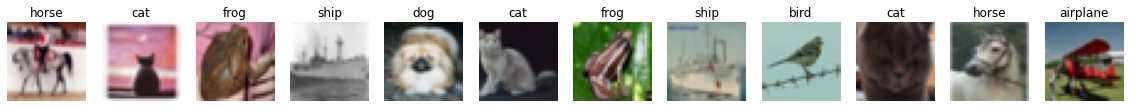

In [ ]:
type(train_dataset)

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)  #*255)   #+128   
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1

In [ ]:
# Example of a Basic Repeating unit

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=False):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU. 
    x = output of repeat_unit
    """
    conv = Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                  kernel_initializer='he_normal')
    x = conv(inputs)
    
    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    return x
 

In [ ]:
# Alternative Repeating unit

def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim=-1,padding="same"):
  """
  Arguments:
  Input: Input to be processed
  No of filters: No of filters that should be in the Conv2D layer.
  FilterX and FilterY: Size of the filters.
  Stride
  Channel dimension
  Padding: Predefined to ‘same’ for the whole model.
  """

  input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

# Inception modue

def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim=-1):
  """
  Step 1: 1×1 filters(used to learn local features in images)
  Step 2: The second and third with 3×3 and 5×5 respectively(responsible for learning general features)
  Step 3: Define the pool projection layer using a global pooling layer
  Step 4: After that, we concatenate the layer outputs along the channel dimension(chanDim)
  """
  # Set the conv layers of sizes 1,3, and 5
  #Step 1
  conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
  #Step 2
  conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
  #Step 3
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
  #Step 4
  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  return input


#Downsample module

def downsample_module(input,No_of_filters,chanDim=-1):
  """ Concatenation of the output of a max-pooling layer and a conv_module(with 3×3 filters) to reduze the number of trainable parameters"""
  conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
  pool = MaxPooling2D((3,3),strides=(2,2))(input)
  input = concatenate([conv_3x3,pool],axis=chanDim)
  return input

In [ ]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset 
    model:       keras Model returned by this function.                          
    """
       
    # Define input of model
    inputs = Input(shape=input_shape)

    # Add First repeating Unit
    # x = repeat_unit(inputs=inputs, num_channels=12)

     

    ######## Add more layers/repeating units to build your Architecture here ##################
    """
    This approach is a version of the GoogLeNet solution build with 22 layers.
    The network is built from convolutional building blocks. 
    All we need is to find the optimal local construction and to repeat it spatially.
    """
        
    # Start with a CONV module of 96 filters
    x = conv_module(inputs, 96, 3, 3, (1, 1))

    # Two Inception modules followed by a downsample module
    x = inception_module(x, 32, 32,32,32)
    x = inception_module(x, 32, 48, 48,32)
    x = downsample_module(x, 80)
    
    # Five Inception modules followed by a downsample module
    x = inception_module(x, 112, 48, 32, 48)
    x = inception_module(x, 96, 64, 32,32)
    x = inception_module(x, 80, 80, 32,32)
    x = inception_module(x, 48, 96, 32,32)
    x = inception_module(x, 112, 48, 32, 48)
    x = downsample_module(x, 96)

    # Two Inception modules followed by Global Average Pooling
    # Note that Global Avg Pooling is not present in the GoogLeNet approach
    x = inception_module(x, 176, 160,96,96)
    x = inception_module(x, 176, 160, 96,96)
    
       
     #############################################  

    

    # Add final stages. (Ensure that you call the output of the very last layer outputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)                                   # Dropout layer should reduce/prevent overfitting. Original model has a dropout of 0.4
    outputs = Dense(num_classes,                          # fully-connected layer
                    activation='softmax',                 # Softmax assigns decimal probabilities to each class in a multi-class problem
                    kernel_initializer='he_normal')(x)    # 'he_normal' draws samples from a truncated normal distribution centered on 0

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 96)   2688        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 96)  384         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_4 (Activation)      (None, 32, 32, 96)   0           ['batch_normalization_11[0][0

In [ ]:
epochs =50
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/50
1407/1407 [==============================] - 82s 55ms/step - loss: 1.1687 - accuracy: 0.5815 - val_loss: 1.3754 - val_accuracy: 0.5487
Epoch 2/50
1407/1407 [==============================] - 70s 50ms/step - loss: 0.7288 - accuracy: 0.7461 - val_loss: 1.1571 - val_accuracy: 0.6131
Epoch 3/50
1407/1407 [==============================] - 70s 50ms/step - loss: 0.5565 - accuracy: 0.8086 - val_loss: 1.0246 - val_accuracy: 0.6642
Epoch 4/50
1407/1407 [==============================] - 70s 50ms/step - loss: 0.4375 - accuracy: 0.8490 - val_loss: 0.8144 - val_accuracy: 0.7351
Epoch 5/50
1407/1407 [==============================] - 70s 50ms/step - loss: 0.3428 - accuracy: 0.8828 - val_loss: 0.8457 - val_accuracy: 0.7502
Epoch 6/50
1407/1407 [==============================] - 70s 50ms/step - loss: 0.2632 - accuracy: 0.9079 - val_loss: 1.2526 - val_accuracy: 0.6920
Epoch 7/50
1407/1407 [==============================] - 70s 50ms/step - loss: 0.2128 - accuracy: 0.9245 - val_loss: 1.8209 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


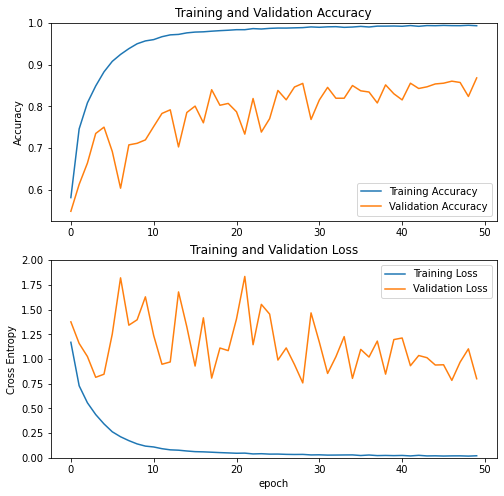

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch) 
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

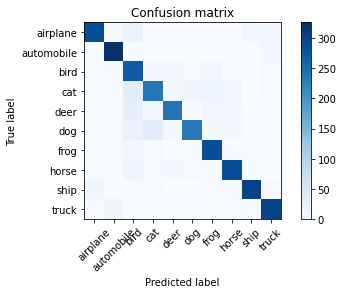

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str)) 

              precision    recall  f1-score   support

    airplane       0.93      0.85      0.89       337
  automobile       0.93      0.96      0.95       338
        bird       0.67      0.89      0.77       306
         cat       0.78      0.73      0.76       323
        deer       0.89      0.81      0.85       297
         dog       0.91      0.72      0.80       325
        frog       0.86      0.94      0.90       307
       horse       0.91      0.91      0.91       317
        ship       0.94      0.93      0.94       326
       truck       0.91      0.94      0.92       324

    accuracy                           0.87      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.88      0.87      0.87      3200



(32, 10)
(32,)
Predictions:
 [2 0 6 9 5 1 7 0 5 2 7 2 7 9 2 8 0 8 7 9 4 2 3 5 3 2 2 8 1 8 6 0]


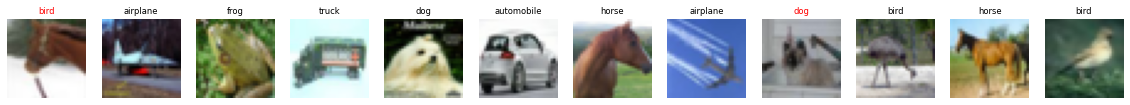

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')
  
  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

##SUMMARY

###Initial Attempt: VGG 
I played around with VGG arch, trying VGG with 1 block up to 3, results below


*   VGG 1: 66.720%
*   VGG 2: 70.330%
*   VGG 3: 74.760%


I attempted to run VGG-3 with Dropout Reg., Data Augmentaton & Batch Normalisation but after 4hrs of running even with the GPU it crashed (the got restricted from using GPU for a few more hours, fun!). I commented out this section but the expectation was that it would give me approx. ~10&% improvement on the above bringing it up to circa 83/84%.

I played around with the optimizers to see what improvements I could get there. I had being used SGD up to this point so tried Adam and RESprop, Adam as expected came out on top:

*   VGG-3 with RES optimizer: 73.080%
*   VGG-3 with Adam optimizer: 76.570

###VGG & tweaking Optimizers

Saved the the VGG-3 with Adam optimizer model and tested it on a single image, had some issues here with getting that to render correctly/call out the correct classifier i.e. class 4 deer. 

Tested this model on a batch of 16 images and ran the confusion matrix and classification_report. The results were not too hot but assuming this is due to fact this is operating at 76% accuracy but unsure of other factors that are bringing the scores down here.

airplane 0.35 0.70 0.47 337
automobile 0.44 0.63 0.52 338
bird 0.35 0.35 0.35 306
cat 0.31 0.27 0.29 323
deer 0.59 0.09 0.16 297
dog 0.40 0.27 0.32 325
frog 0.32 0.72 0.44 307
horse 0.73 0.19 0.30 317
ship 0.48 0.42 0.45 326
truck 0.71 0.27 0.40 324
accuracy 0.40 3200
macro avg 0.47 0.39 0.37 3200
weighted avg 0.47 0.40 0.37 3200

###VGG & adding Dropout, Data Augmentation & Batch Normalization

Post that I went back (after upgrading to CollabPro) and ran the VGG 3 block with Adam optimizer which resulted in an accuracy of 76% and once put under the test to predict it did quite poorly, 40ish %. I ran the same model but with Dropout, Data Augmentation & Batch Normalization first with 50 epochs which gave a 86% accuracy but looked to overfit and misclassify quite a lot at prediction stage. I then up'ed the Epochs to 400 and got an accuracy of 90% but did this an even worse job on classifying the photos - I believe from overfitting and that removing or lowering Augmentation would help.

###Provided Structure/Code + GoogleNet inspired architecture
At this point I wanted to try a different approach leveraging more of the e-tivity provided structure/code and leveraging GoogLeNet architecture to a degree. This performed a lot better in that it had a slightly lower accuracy at 86% but it was far better at validation and classifing the pics with a precision of up to 93% and big improvement in F1.

##REFERENCES 

*   https://machinelearningmastery.com/ - Various sites focuse on VGG
*   https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c

